In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [2]:
#イチロー
df=pd.read_csv("ichiro.csv",header=None)
#ナイル川
#df=sm.datasets.nile.load_pandas().data.astype(int)
#df.columns=[0,1]

In [3]:
df.head()

,0,1,2,3
0,1992,24,40,0.60
1,1993,12,43,0.28
2,1994,210,130,1.62
3,1995,179,130,1.38
4,1996,193,130,1.48


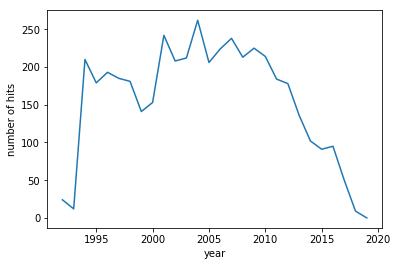

In [4]:
plt.plot(df[0],df[1])
plt.xlabel("year")
plt.ylabel("number of hits")
plt.show()

In [5]:
#最後の5年分をカット
df=df.iloc[:-5,:]

In [6]:
def localLevelModel(y, xPre, pPre, sigmaW, sigmaV):
    # 状態の予測(ローカルレベルモデルなので、予測値は、前期の値と同じ)
    xForecast = xPre

    # 状態の予測誤差の分散
    pForecast = pPre + sigmaW

    # カルマンゲイン
    kGain = pForecast / (pForecast + sigmaV)

    # カルマンゲインを使って補正された状態
    xFiltered = xForecast + kGain * (y - xForecast)

    # 補正された状態の予測誤差の分散
    pFiltered = (1 - kGain) * pForecast

    # 観測値の予測誤差
    v = y - xForecast

    # 観測値の予測誤差の分散
    F = pForecast + sigmaV
    
    return xFiltered,pFiltered,v,F

In [7]:
def kalmanfilter(df,sigmaW=1000,sigmaV=10000,optimize=False):
    x=np.zeros(df.shape[0]+1)
    P=np.zeros(df.shape[0]+1)
    v=np.zeros(df.shape[0])
    F=np.zeros(df.shape[0])
    
    #状態の予測誤差の分散」の初期値
    P[0]=10000000
    
    for i in range(df.shape[0]):
        x[i + 1],P[i + 1],v[i],F[i] = localLevelModel(df[1].values[i], x[i], P[i], sigmaW = sigmaW, sigmaV = sigmaV)
        
    #尤度の計算
    if optimize==True:
        #return(1/2 * sum(np.log(F) + v**2 / F))
        return -norm_dens(v, np.sqrt(F)).sum()
    else:
        return x,P,v,F

In [8]:
#尤度を計算する
def norm_dens(val, s):
    #val:値
    #s:標準偏差
    return np.log((1/np.sqrt(2*np.pi*s**2))*np.exp(-0.5*(val)**2/s**2))

In [9]:
#最尤推定
from scipy.optimize import fmin
import math
yu = lambda X: kalmanfilter(df,X[0],X[1],optimize=True)
result=fmin(yu, [1000, 1000])

Optimization terminated successfully.
         Current function value: 127.105195
         Iterations: 58
         Function evaluations: 115


In [10]:
result

array([1635.79921897,  594.56116963])

In [11]:
#最尤推定したパラメータで予測値を算出
x,p,v,f=kalmanfilter(df,result[0], result[1])

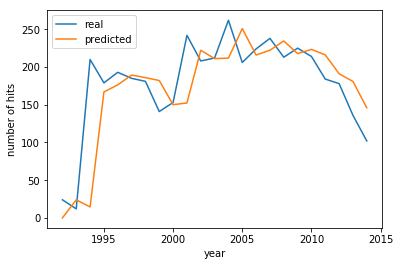

In [12]:
plt.plot(df[0],df[1],label="real")
plt.plot(df[0],x[:-1],label="predicted")
plt.xlabel("year")
plt.ylabel("number of hits")
plt.legend()
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                   23
Model:                    local level   Log Likelihood                -118.127
Date:                Wed, 10 Apr 2019   AIC                            240.254
Time:                        08:21:54   BIC                            242.436
Sample:                             0   HQIC                           240.768
                                 - 23                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   594.1718   1615.132      0.368      0.713   -2571.430    3759.773
sigma2.level      1636.5036   2767.862      0.591      0.554   -3788.406    7061.413
Ljung-Box (Q):              

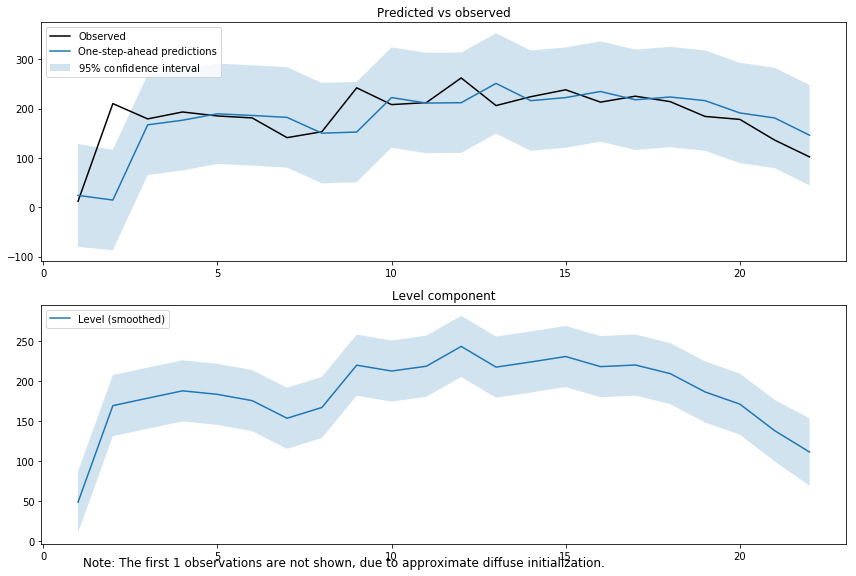

In [13]:
#ライブラリを使用した場合
# Unobserved Components Modeling (via Kalman Filter)の実行
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(df[1].values, 'local level')
res_ll = mod_ll.fit()

print(res_ll.summary())
# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components(legend_loc="upper left", figsize=(12,8))
plt.tight_layout()

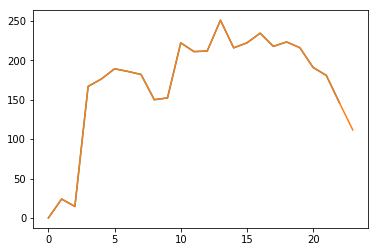

In [14]:
#自分で計算した予測値とライブラリで計算した予測値の比較
#plt.plot(df[1])
plt.plot(res_ll.predict())
plt.plot(x)